In [3]:
import numpy as np
from OABS_vertex_calc import *
import time
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import scipy as sp
from matplotlib.colors import LogNorm
import matplotlib as mpl

# preamble

previous work used a bindng model where there is a penalty to binding opposite type. I had to do a redefiniton of types in order to match th ehost profiles 

(In andys transfer matrix method, the binding affinity is the favorabel energy for binding to same type. I input values of opposite sign, such that there wasa penalty to binding same type. This means that the A guests preferentially bind B hosts. The system is symmetric, so can just reclassify the host types (and thus switch host profile) to get the identical behavior of a correctly labeled system. Still, this redefined system is one where there is a penalty to binding opposite type) 

This document now wants to use a binding a model where there is a benefit to binding same type. The binding affinity only appears in the binding calculation. This preamble shows that this change in bingind affintiny manifests by shifting the chemical potnetials considered (2 *eps_B / 2)

# schematic

## gen

### binding functions

In [94]:
def eval_tmat(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    # boltzmann weightings of all possible binding states of the two nucleosommes. essentially all possible non-normalized joint probabilities
    tmat = np.zeros((3,3))
    for n1 in range(3):
        for n2 in range(3):
            if (n1 == 0 and n2 == 0):
                f_tot = 0.
            elif (n1 == 0 and n2 == 1):
                f_tot = 0.5 * (-mu_a + ea2)
            elif (n1 == 1 and n2 == 0):
                f_tot = 0.5 * (-mu_a + ea1)
            elif (n1 == 0 and n2 == 2):
                f_tot = 0.5 * (-mu_b + eb2)
            elif (n1 == 2 and n2 == 0):
                f_tot = 0.5 * (-mu_b + eb1)
            elif (n1 == 1 and n2 == 1):
                f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
            elif (n1 == 1 and n2 == 2):
                f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
            elif (n1 == 2 and n2 == 1):
                f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
            elif (n1 == 2 and n2 == 2):
                f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb

            f_tot -= f_ref
            tmat[n1, n2] = np.exp(-f_tot)
                    
    return tmat
    
def eval_tend(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    tend = np.zeros((3))
    tend[0] = 1
    
    f_tot = 0.5 * (-mu_a + ea)
    f_tot -= f_ref
    tend[1] = np.exp(-f_tot)

    f_tot = 0.5 * (-mu_b + eb)
    f_tot -= f_ref
    tend[2] = np.exp(-f_tot)
                    
    return tend    

def eval_dtdmu(mu_a, mu_b, ea1 = 0, ea2 = 0, eb1 = 0, eb2 = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    dtda1 = np.zeros((3,3))
    dtda2 = np.zeros((3,3))
    dtdb1 = np.zeros((3,3))
    dtdb2 = np.zeros((3,3))
    for n1 in range(3):
        for n2 in range(3):
            if (n1 == 0 and n2 == 0):
                f_tot = 0.
                f_tot -= f_ref
            elif (n1 == 0 and n2 == 1):
                f_tot = 0.5 * (-mu_a + ea2)
                f_tot -= f_ref
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 0):
                f_tot = 0.5 * (-mu_a + ea1)
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 0 and n2 == 2):
                f_tot = 0.5 * (-mu_b + eb2)
                f_tot -= f_ref
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 0):
                f_tot = 0.5 * (-mu_b + eb1)
                f_tot -= f_ref
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 1):
                f_tot = 0.5 * (-2 * mu_a + ea1 + ea2) + j_aa
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 1 and n2 == 2):
                f_tot = 0.5 * (-mu_a - mu_b + ea1 + eb2) + j_ab
                f_tot -= f_ref
                dtda1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 1):
                f_tot = 0.5 * (-mu_a - mu_b + ea2 + eb1) + j_ab
                f_tot -= f_ref
                dtda2[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
            elif (n1 == 2 and n2 == 2):
                f_tot = 0.5 * (-2 * mu_b + eb1 + eb2) + j_bb
                f_tot -= f_ref
                dtdb1[n1, n2] = 0.5 * np.exp(-f_tot)
                dtdb2[n1, n2] = 0.5 * np.exp(-f_tot)
        
    return dtda1, dtda2, dtdb1, dtdb2

def eval_dtenddmu(mu_a, mu_b, ea = 0, eb = 0, f_ref = 0):
    r"""
    eval_tmat - Evaluate the transfer matrix or the nucleosome
    
    Parameters
    ----------
    mu : float
        HP1 chemical potential
    nm1 : int
        Number of methylated tails in the left-side nucleosome
    nm2 : int
        Number of methylated tails in the right-side nucleosome
    nu : int
        Indicator for nucleosomes within the interaction length
    j_int : float
        Strength of the HP1 interactions
    
    Returns
    -------
    tmat : 3x3 float array
        Transfer matrix for the nucleosome    
    
    """
    
    dtendda = np.zeros((3))
    dtenddb = np.zeros((3))
    
    f_tot = 0.5 * (-mu_a + ea)
    f_tot -= f_ref
    dtendda[1] = 0.5 * np.exp(-f_tot)

    f_tot = 0.5 * (-mu_b + eb)
    f_tot -= f_ref
    dtenddb[2] = 0.5 * np.exp(-f_tot)
                    
    return dtendda, dtenddb

def eval_phi(sig, mu_a = 0, mu_b = 0, ea = 0, eb = 0, j_aa = 0, j_bb = 0, j_ab = 0, f_ref = 0):
    
    nm = len(sig)
    phiva = np.zeros((nm, 3))
    phivb = np.zeros((nm, 3))
    phia = np.zeros((nm))
    phib = np.zeros((nm))
    
    # Evaluate binding for the first bead
    # print("first bead binding:")
    ea2 = (1 - sig[0]) * ea
    eb2 = sig[0] * eb
    tend = eval_tend(mu_a, mu_b, ea2, eb2, f_ref)
    # print("tend: ", tend)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea2, eb2, f_ref)
    # print("dtend/dmu_a :", dtendda)
    # print("dtend/dmu_b :", dtenddb)
    
    q_vec = tend
    # print("q_vec: ", q_vec)
    
    phiva[0, :] = dtendda
    phivb[0, :] = dtenddb
    for j in range(1, nm):
        phiva[j, :] = tend
        phivb[j, :] = tend

    # print("phiva: ", phiva)
    # print("phivb: ", phivb)
    
    # Evaluate binding for the intermediate beads
    # print("intermediate bead binding:")
    for i in range(0, nm - 1):
        # print(" --- nucleosome %s ---" % str(i+1))
        ea1 = ea2
        eb1 = eb2
        ea2 = (1 - sig[i + 1]) * ea
        eb2 = sig[i + 1] * eb
        
        tmat = eval_tmat(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
        # print("tmat: ", tmat)
        dtda1, dtda2, dtdb1, dtdb2 = eval_dtdmu(mu_a, mu_b, ea1, ea2, eb1, eb2, j_aa, j_bb, j_ab, f_ref)
        
        # print("dt/dmu_a1: ", dtda1)
        # print("dt/dmu_a2: ", dtda2)
        # print("dt/dmu_b1: ", dtdb1)
        # print("dt/dmu_b2: ", dtdb2)
        
        q_vec = np.matmul(q_vec, tmat) # collecting all possibilites for eventual full partition function

        # print("updated q_vec (matmul q_vec and tmat): ", q_vec)
        
        # # print(q_vec)
        # print("old phiva: ", phiva)
        # print("old phivb: ", phivb)
        
        for j in range(0, nm):
            if j == i:
                phiva[j, :] = np.matmul(phiva[j, :], tmat) + np.matmul(phiva[i + 1, :], dtda1)
                phivb[j, :] = np.matmul(phivb[j, :], tmat) + np.matmul(phivb[i + 1, :], dtdb1)
            elif j == (i + 1):
                phiva[j, :] = np.matmul(phiva[j, :], dtda2)
                phivb[j, :] = np.matmul(phivb[j, :], dtdb2)
            else:
                phiva[j, :] = np.matmul(phiva[j, :], tmat)
                phivb[j, :] = np.matmul(phivb[j, :], tmat)

        # print("new phiva: ", phiva)
        # print("new phivb: ", phivb)
    
    # Evaluate binding for the last bead

    # print("last bead binding:")
    
    ea1 = ea2
    eb1 = eb2

    tend = eval_tend(mu_a, mu_b, ea1, eb1, f_ref)
    dtendda, dtenddb = eval_dtenddmu(mu_a, mu_b, ea1, eb1, f_ref)

    # print("tend: ", tend)
    # print("dtendda, dtendda: ", dtendda, dtendda)

    q = np.matmul(q_vec, tend)
    phia[nm - 1] = (np.matmul(q_vec, dtendda) + np.matmul(phiva[nm - 1, :], tend)) / q
    phib[nm - 1] = (np.matmul(q_vec, dtenddb) + np.matmul(phivb[nm - 1, :], tend)) / q
    for j in range(0, nm - 1):
        phia[j] = np.matmul(phiva[j, :], tend) / q
        phib[j] = np.matmul(phivb[j, :], tend) / q
    
    return phia, phib

### code

In [ ]:
num_mon = nm
steps = np.random.randn(num_mon,3)
# Compute cumulative sum to get positions
poly = np.cumsum(steps, axis=0)

In [117]:
nm = 100
ea = -1.52
eb = -1.52
j_aa = -4
j_bb = -4
j_ab = 4

mu_a = -5.5
mu_b = -5.5

f_ref = np.min(np.array([j_aa, j_bb, j_ab, ea, eb]))

sig = np.zeros((nm))
for i in range(nm):
    pb = i / (nm - 1)    
    if np.random.uniform() < pb:
        sig[i] = 1
    else:
        sig[i] = 0

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_44 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_44[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_44[i] = 1
    else:
        identity_44[i] = 0
identity_44 = identity_44.astype(int)

mu_a = -4.5
mu_b = -4.5

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_33 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_33[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_33[i] = 1
    else:
        identity_33[i] = 0
identity_33 = identity_33.astype(int)

mu_a = -3.5
mu_b = -4.5

phia, phib = eval_phi(sig, mu_a, mu_b, ea, eb, j_aa, j_bb, j_ab, f_ref)
phiu = 1-phia-phib

identity_295_3 = np.zeros(nm)
for i in range(nm):
    draw = np.random.rand()
    if draw<phia[i]:
        identity_295_3[i] = 2
    elif draw>phia[i] and draw<phib[i]:
        identity_295_3[i] = 1
    else:
        identity_295_3[i] = 0
identity_295_3 = identity_295_3.astype(int)


In [123]:
# np.save("poly_100mons_schem2.npy", poly)
np.save("identity_n3.5n4.5_schem2.npy", identity_295_3)
np.save("identity_n4.5n4.5_schem2.npy", identity_33)
np.save("identity_n5.5n5.5_schem2.npy", identity_44)

## load

In [125]:

poly = np.load("poly_100mons_schem2.npy")
identity_295_3 = np.load("identity_n3.5n4.5_schem2.npy")
identity_33 = np.load("identity_n4.5n4.5_schem2.npy")
identity_44 = np.load("identity_n5.5n5.5_schem2.npy")


## figure

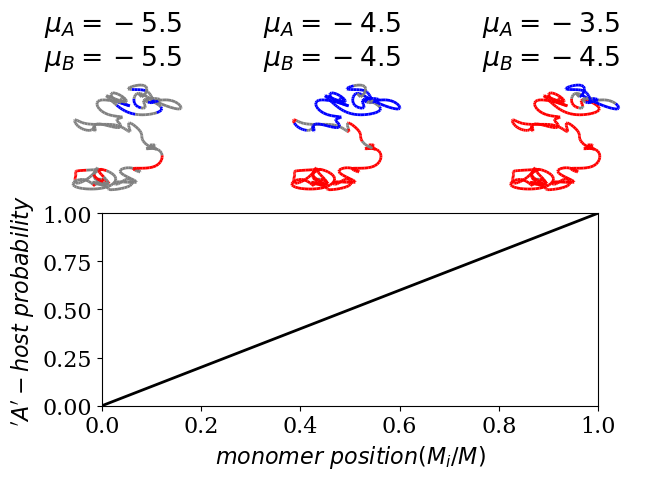

In [130]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

def plot_colored_curve(ax, points, identities, title):
    tck, u = splprep([points[:, 0], points[:, 1], points[:, 2]], s=2)
    u_fine = np.linspace(0, 1, 500)
    x_smooth, y_smooth, z_smooth = splev(u_fine, tck)

    identity_interp = interp1d(u, identities, kind='nearest', bounds_error=False, fill_value='extrapolate')
    identities_fine = identity_interp(u_fine)

    color_map = {0: 'grey', 1: 'blue', 2: 'red'}
    points_smooth = np.array([x_smooth, y_smooth, z_smooth]).T
    segments = np.array([points_smooth[:-1], points_smooth[1:]]).transpose(1, 0, 2)

    colors = [color_map.get(val, 'black') for val in identities_fine[:-1]]
    lc = Line3DCollection(segments, colors=colors, linewidth=2)
    ax.add_collection(lc)

    ax.set_xlim(points[:, 0].min(), points[:, 0].max())
    ax.set_ylim(points[:, 1].min(), points[:, 1].max())
    ax.set_zlim(points[:, 2].min(), points[:, 2].max())
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(title, y=0.95)

# Example: your data
points = poly  # shape (N, 3)
identity_1 = identity_295_3
identity_2 = identity_33
identity_3 = identity_44

fig = plt.figure(figsize=(8, 5))
font = {'family' : 'serif', 'weight':'normal', 'size': 16}
plt.rc('font', **font)

# Setup GridSpec: 2 rows, 3 columns
gs = gridspec.GridSpec(2, 3, height_ratios=[5, 5], hspace=-.0)  # Top row taller

# Top 3 plots
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
plot_colored_curve(ax1, points, identity_44, r"$\mu_A = -5.5$" +"\n" + "$\mu_B = -5.5$")

ax2 = fig.add_subplot(gs[0, 1], projection='3d')
plot_colored_curve(ax2, points, identity_33,  r"$\mu_A = -4.5$" +"\n" + "$\mu_B = -4.5$")#) r"$\mu = [-3.25, -3.25]$")

ax3 = fig.add_subplot(gs[0, 2], projection='3d')
plot_colored_curve(ax3, points, identity_295_3,  r"$\mu_A = -3.5$" +"\n" + "$\mu_B = -4.5$")#r"$\mu = [-2.95, -3.25]$")

# Bottom plot: span all 3 columns
ax_bottom = fig.add_subplot(gs[1, :])  # ":" means span all columns

# Plot linear profile from (0,0) to (1,1)
ax_bottom.plot([0, 1], [0, 1], color='black', linewidth=2)
pos = ax_bottom.get_position()  # Get current position
ax_bottom.set_position([pos.x0 + 0.1, pos.y0+0.05, pos.width *0.8, pos.height])
# Make the bottom plot rectangular and clean
ax_bottom.set_xlim(0, 1)
ax_bottom.set_ylim(0, 1)
ax_bottom.set_xlabel(r"$monomer \  position (M_i / M)$")
ax_bottom.set_ylabel(r"$ 'A'-host \ probability$")
ax_bottom.grid(False)

plt.savefig('schematic2_alt.eps', format='eps')
# plt.savefig('schematic2.svg', format='svg')
# plt.savefig('schematic2.png', format='png')

plt.show()


# binding map

In [71]:
n_bind = 2 #types of proteins/marks
e_m = np.array([-1.52, -1.52]) #
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.7
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

#  density map
mu_max_1 = -1.999 - 1.5#1.52*2
mu_min_1 = -5 - 1.5#1.52*2
# del_mu_1 = .01#.5 #0.25
# # # EDITTTTTTTTTTTTTTTTTTTTTTTTTT FOR FASTER JUST CHECK HO WBIND AFF CHANGES THINGS
# # # CHAGNE BACKKKK
del_mu_1 = .01#.5 #0.25

mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

mu1_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
mu2_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

# #  density map using xn50
# mu_max_1xn = -2#8#0.1 #10
# mu_min_1xn = -4#-9
# del_mu_1xn = .0025#.5 #0.25
# mu_max_2xn = mu_max_1xn
# mu_min_2xn = mu_min_1xn
# del_mu_2xn = del_mu_1xn

# mu1_arr_xn = np.arange(mu_min_1xn, mu_max_1xn, del_mu_1xn)
# mu2_arr_xn = np.arange(mu_min_2xn, mu_max_2xn, del_mu_2xn)
# v_s = 1
# v_m = 1
# N = 5000
# b = 1

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, poly_marks, mu1_arr, mu2_arr, v_s, v_m, N, b)

competitive = True

klog_min = -2.5
klog_max = -.1
klog_num = 30
k_vec = np.logspace(klog_min, klog_max, klog_num) / b

## gen

In [73]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)

CPU times: total: 1h 4min 34s
Wall time: 1h 7min 17s


In [74]:
#REAL
fa_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fb_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fab_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1
fo_mat = np.zeros((len(mu1_arr), len(mu2_arr))) - 1

for i, mu1 in enumerate(mu1_arr[:]):
    for j, mu2 in enumerate(mu2_arr[:]):
        s_Abnd_ar = s_bind_A_ALL[i,j]
        s_Bbnd_ar = s_bind_B_ALL[i,j]
        f_a, f_b, f_ab, f_o = calc_fas(s_Abnd_ar, s_Bbnd_ar)
        fa_mat[i,j] = f_a
        fb_mat[i,j] = f_b
        fab_mat[i,j] = f_ab
        fo_mat[i,j] = f_o

In [85]:
np.save("s_bind_A_densitymap_ALT.npy", s_bind_A_ALL)
np.save("s_bind_B_densitymap_ALT.npy", s_bind_B_ALL)

In [87]:
np.save("fa_mat_densitymap_highres_ALT.npy", fa_mat)
np.save("fb_mat_densitymap_highres_ALT.npy", fb_mat)

## load

In [ ]:
fa_mat = np.load("fa_mat_densitymap_highres_ALT.npy")
fb_mat = np.load("fb_mat_densitymap_highres_ALT.npy")

s_bind_A_ALL = np.load("s_bind_A_densitymap_ALT.npy")
s_bind_B_ALL = np.load("s_bind_B_densitymap_ALT.npy")

## figure

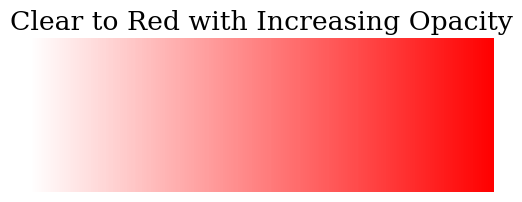

In [75]:
# Define colors: white (fully transparent) to bright red (fully opaque)
colors = [(1, 0, 0, 0), (1, 0, 0, 1)]  # RGBA: white (transparent) to red (opaque)

# Create a colormap
cmap_name = 'clear_to_red_alpha'
red_cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

colors = [(0, 0, 1, 0), (0, 0, 1, 1)]  # RGBA: white (transparent) to red (opaque)

# Create a colormap
cmap_name = 'clear_to_blue_alpha'
blue_cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Display the colormap as a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=red_cmap)
ax.set_axis_off()
plt.title("Clear to Red with Increasing Opacity")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


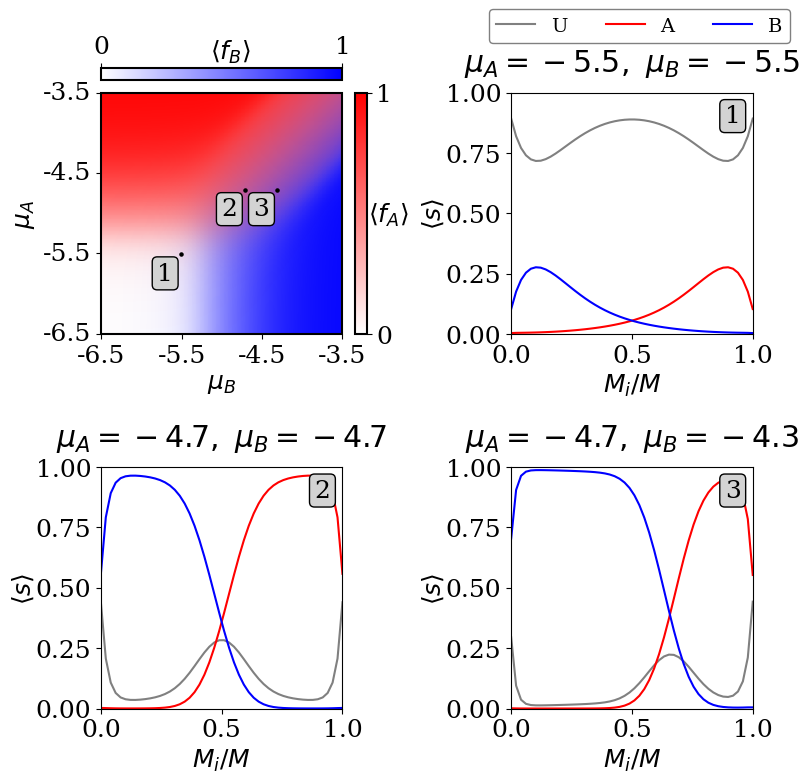

In [89]:
# EDIT FORNLOWER RES!!
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 layout

# Flatten axes array for easier access
ax1, ax2, ax3, ax4 = axes.flatten()

# Plot 1: heatmap on top-left
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

mu2_array = np.round(mu2_arr,2)
mu1_array = np.round(mu1_arr,2)

# fig, ax = plt.subplots(figsize=(4, 5))
ax = ax1
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
fontsize=18
plt.rc('font', **font)
vmin=0
vmax=1
# First heatmap
hm1 = sns.heatmap(fb_mat, linewidth=0.0, cmap=blue_cmap,
                  xticklabels=mu2_array, yticklabels=mu1_array,
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax)
# pos = ax.get_position()  # get the position of the axes in figure coordinates
# rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
#                          linewidth=1.5, edgecolor='black', facecolor='none',
#                          transform=fig.transFigure, zorder=10)

# fig.patches.append(rect)

# Manually add colorbar 1
cax1 = inset_axes(ax, width="100%", height="5%", loc='upper right',
                  bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
                  bbox_transform=ax.transAxes, borderpad=0)

cb1 = fig.colorbar(hm1.collections[0], cax=cax1, orientation='horizontal', ticks=[0,  1])

# cb1.set_label(r'$ \langle f_B \rangle $')
cb1.outline.set_edgecolor('black')
cb1.outline.set_linewidth(1.5)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.ax.text(.45, 1.25, r'$ \langle f_B \rangle $',
            transform=cb1.ax.transAxes,
            fontsize=fontsize, ha='left', va='bottom')
# # Manually add colorbar 1
# cax1 = inset_axes(ax, width="5%", height="50%", loc='upper left',
#                   bbox_to_anchor=(1, 0.1, 1, 1),  # adjust left/right with -0.15
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb1 = fig.colorbar(hm2.collections[0], cax=cax1)
# cb1.set_label(r'$ \langle f_B \rangle $')
# cb1.outline.set_edgecolor('black')
# cb1.outline.set_linewidth(1.5)

# Second heatmap (overlayed)
hm2 = sns.heatmap(fa_mat, linewidth=0.0, cmap=red_cmap,
                  xticklabels=np.round(mu2_array, 3), yticklabels=np.round(mu1_array,3),
                  cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax)

# # Manually add colorbar 2
# cax2 = inset_axes(ax, width="100%", height="5%", loc='upper right',
#                   bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, orientation='horizontal')
# cb2.set_label(r'$ \langle f_A \rangle $')
# cb2.outline.set_edgecolor('black')
# cb2.outline.set_linewidth(1.5)


# Manually add colorbar 2
cax2 = inset_axes(ax, width="5%", height="100%", loc='upper left',
                  bbox_to_anchor=(1.05, 0.0, 1, 1),  # adjust left/right with -0.15
                  bbox_transform=ax.transAxes, borderpad=0)

cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, ticks=[0, 1])
# cb2.set_label(r'$ \langle f_A \rangle $')
cb2.outline.set_edgecolor('black')
cb2.outline.set_linewidth(1.5)
cb2.ax.text(1.08, 0.55, r'$ \langle f_A \rangle $',
            transform=cb2.ax.transAxes,
            fontsize=fontsize, ha='left', va='top', rotation=0)


# Parameters for the box (adjust these to highlight your region)
x_start = 200       # column index (left edge)
y_start = 200       # row index (top edge)
width = 35         # number of columns to span
height = 35        # number of rows to span

# # Create and add the rectangle
# rect = patches.Rectangle(
#     (x_start, y_start),     # bottom-left corner (note: heatmap coords go left-right, bottom-top)
#     width,
#     height,
#     linewidth=2,
#     edgecolor='black',
#     linestyle='--',
#     facecolor='none', alpha = 0.5
# )

# Add to the same axes as the heatmap
# ax.add_patch(rect)


spacing = 100
# spacing = 10

hm1.set_xticks(hm1.get_xticks()[::spacing])
hm1.set_xticklabels(np.round(mu2_arr[::spacing], 3))
hm1.set_yticks(hm1.get_yticks()[::spacing])
hm1.set_yticklabels(np.round(mu1_arr[::spacing],3))
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=0)  # <- Set labels horizontal here
# ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")
low = [-4-1.5, -4-1.5]
sym = [-3.2-1.5, -3.2-1.5]
cyl = [-3.2-1.5, -2.8-1.5]

#orig
mu1_ind = np.where(np.round(mu1_arr,4) == low[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == sym[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2 = [mu1_ind, mu2_ind]
mu1_ind = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]
mu2_ind = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3 = [mu1_ind, mu2_ind]

# p1 = [100,100]
# p2 = [175,175]
# p3 = [175, 215]

# ofst=2
# hm1.text(p1[1]-ofst,p1[0]-ofst, "1")
# hm1.text(p2[1]-ofst,p2[0]-ofst, "2")
# hm1.text(p3[1]-ofst,p3[0]-ofst, "3")

# hm1.scatter(100,100, color = "black", s = 5) #1
# hm1.scatter(175,175, color = "black", s = 5) #2
# hm1.scatter(205,175, color = "black", s = 5) #3
# crc = 100
# hm1.scatter(p1[1]+crc,p1[0]+crc, color = "black", s = 5) #1
# hm1.scatter(p2[1]+crc,p2[0]+crc, color = "black", s = 5) #2
# hm1.scatter(p3[1]+crc,p3[0]+crc, color = "black", s = 5) #3

p1x = np.where(np.round(mu2_arr,4) == low[1])[0][0]
p1y = np.where(np.round(mu1_arr,4) == low[0])[0][0]

p2x = np.where(np.round(mu2_arr,4) == sym[1])[0][0]
p2y = np.where(np.round(mu1_arr,4) == sym[0])[0][0]

p3x = np.where(np.round(mu2_arr,4) == cyl[1])[0][0]
p3y = np.where(np.round(mu1_arr,4) == cyl[0])[0][0]

hm1.scatter(p1x,p1y, color = "black", s = 5) #1
hm1.scatter(p2x,p2y, color = "black", s = 5) #2
hm1.scatter(p3x,p3y, color = "black", s = 5) #3

ofst=10
hm1.text(p1x-ofst,p1y-ofst, "1",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p2x-ofst,p2y-ofst, "2",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
hm1.text(p3x-ofst,p3y-ofst, "3",
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# ax.scatter(10,10, marker = "*")
# ax.scatter(10,10, marker = "*")
hm1.invert_yaxis()

hm1.set_ylabel("$\mu_A$")
hm1.set_xlabel("$\mu_B$")



# plt.tight_layout()
# plt.show()

# Plot 2: e.g. line plot on top-right
# mu1 = -4
# mu2 = -4
mu1 = np.round(mu1_arr[p1[0]],2)
mu2 = np.round(mu2_arr[p1[1]],2)

# mu1_ind = np.where(mu1_array == mu1)[0][0]
# mu2_ind = np.where(mu2_array == mu2)[0][0]
mu1_ind = p1[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p1[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

xvals = np.linspace(0,1,len(s_bnd_A))


ax2.plot(xvals, s_unbnd, color = "grey", label = "U")

ax2.plot(xvals, s_bnd_A, color = "red", label = "A")
ax2.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax2.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax2.set_xlim(0,1)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])

# ax2.set_xlabel("M")
ax2.set_xlabel(r"$M_i/M$")

ax2.set_ylabel(r"$\langle s \rangle$", labelpad=0)
# ax2.plot(x_vals, y_vals, color='red')
ax2.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)

# Plot 3: e.g. bar plot bottom-left

mu1 = np.round(mu1_arr[p2[0]],2)
mu2 = np.round(mu2_arr[p2[1]],2)

# mu1_ind = np.where(np.round(mu1_array,2) == mu1)[0][0]
# mu2_ind = np.where(np.round(mu2_array,2) == mu2)[0][0]
mu1_ind = p2[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p2[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax3.plot(xvals, s_unbnd, color = "grey", label = "U")

ax3.plot(xvals, s_bnd_A, color = "red", label = "A")
ax3.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax3.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax3.set_xlim(0,1)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax3.set_xticks([0, 0.25, 0.5, 0.75, 1])

ax3.set_xlabel(r"$M_i/M$")
ax3.set_ylabel(r"$\langle s \rangle$" ,labelpad = 0)
ax3.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)
# Plot 4: e.g. scatter plot bottom-right

# mu1 = np.round(mu1_arr[175],2)
# mu2 = np.round(mu2_arr[205],2)
mu1 = np.round(mu1_arr[p3[0]],2)
mu2 = np.round(mu2_arr[p3[1]],2)

mu1_ind = p3[0]#np.where(np.round(mu1_arr_xn,2) == mu1)[0][0]
mu2_ind = p3[1]#np.where(np.round(mu2_arr_xn,2) == mu2)[0][0]


s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]

s_unbnd = 1 - (s_bnd_A+s_bnd_B)

ax4.plot(xvals, s_unbnd, color = "grey", label = "U")

ax4.plot(xvals, s_bnd_A, color = "red", label = "A")
ax4.plot(xvals, s_bnd_B, color = "blue", label = "B")
ax4.set_ylim(0,1)
# ax4.set_xlim(0,50)
ax4.set_xlim(0,1)
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax4.set_xticks([0, 0.25, 0.5, 0.75, 1])


# ax4.set_xlabel("M")
ax4.set_xlabel(r"$M_i/M$")

ax4.set_ylabel(r"$\langle s \rangle$", labelpad = 0)
# ax4.scatter(x_scatter, y_scatter)
# ax4.set_title("Scatter Plot")
ax4.set_title(r"$\mu_A = %s, \ \mu_B = %s$" % (mu1, mu2), pad = 15)

# plt.tight_layout()

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.125, hspace=0.55)

# Gather legend handles from one plot (they're identical)
handles, labels = ax2.get_legend_handles_labels()

# # Add a single legend on the right side of the figure
# # fig.legend(handles, labels, loc='center right', title="States", fontsize=fontsize, title_fontsize=fontsize+1, bbox_to_anchor=(1.08, 0.5))
# fig.legend(handles, labels, loc='center right', fontsize=fontsize, bbox_to_anchor=(1.08, 0.5))

# fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
# Shift the figure layout to make room for the legend
# fig.subplots_adjust(right=0.95)  # adjust as needed

pos = ax.get_position()  # get the position of the axes in figure coordinates
rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
                         linewidth=1.5, edgecolor='black', facecolor='none',
                         transform=fig.transFigure, zorder=10)

fig.patches.append(rect)

fig.legend(handles, labels,
           loc='lower center',
           bbox_to_anchor=(0.725, .93),  # (x, y)
           ncol=3,
           frameon=True,
           framealpha=1,
           edgecolor='grey',
           fontsize=14)

# Add "1" inside ax2 (top-right)
ax2.text(0.95, 0.95, "1", transform=ax2.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "2" inside ax3 (bottom-left)
ax3.text(0.95, 0.95, "2", transform=ax3.transAxes,
     
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))

# Add "3" inside ax4 (bottom-right)
ax4.text(0.95, 0.95, "3", transform=ax4.transAxes,
         fontsize=fontsize, color='black',
         ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.2", fc="lightgray", ec="black"))
# plt.show()
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

plt.savefig('bingingmap_fig3_ALT.eps', format='eps')
# plt.savefig('bingingmap_fig3.pdf', format='pdf')

# plt.savefig('bingingmap_fig3.png')

plt.show()

In [91]:
plt.savefig('bingingmap_fig3_ALT.png')

<Figure size 640x480 with 0 Axes>